In [1]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'

### Truth file settings
truthFileName='../data/proc/truth.nc'

### Other run settings
runningLocation = 'local'
if  runningLocation== 'local':
    obsFilePath='../data/raw/'
    modFilePath='../data/raw/'
    modFilePathOld='../data/raw/run1/'
    obsFilePathOld='../data/raw/run1/'
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
obsPrefix = 'eac_obs_'
modPrefix = 'eac_mod_'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [2]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    etaRange=range(etaRange[0],etaRange[1]+1)
    xiRange=range(xiRange[0],xiRange[1]+1)
    output = input.isel(eta_rho=etaRange, xi_rho=xiRange).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

# Processed SST data - look at values of obs_zgrid, obs_value, obs_type

In [3]:
### raw SST obs

raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/SST_Himawari_synth/obs_SST_8005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values)
print(raw.obs_Zgrid.values)
print(raw.obs_value.values)
print(raw.obs_type.values)



[30. 30. 30. ... 30. 30. 30.]
[0. 0. 0. ... 0. 0. 0.]
[25. 25. 25. ... 25. 25. 25.]
[6 6 6 ... 6 6 6]


# Processed SSH data - look at values of obs_zgrid, obs_value, obs_type

In [4]:
## raw SSH obs
raw = xr.open_dataset('/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/SSH_alongtrack/obs_SSH_8005.nc')

# raw.NLmodel_final.where(mod.obs_provenance==pRange, drop=True).values
print(raw.obs_depth.values, raw.obs_depth.values.mean())
print(raw.obs_Zgrid.values, raw.obs_Zgrid.values.mean())
print(raw.obs_value.values, raw.obs_value.values.mean())
print(raw.obs_type.values, raw.obs_type.values.mean())

[0. 0. 0. ... 0. 0. 0.] 0.0
[30. 30. 30. ... 30. 30. 30.] 30.0
[0.26258642 0.26918461 0.28351284 ... 0.39997864 0.40547864 0.40883844] 0.3808204608409331
[1 1 1 ... 1 1 1] 1.0


# Plot up SSH and SST from merged Obs file.
This is the file put in the verification/ folder that is used to force the truth run, and return the first mod file. It should have 'dummy' values of sst and ssh, but at realistic locations/times.

In [5]:
### Load osse obs and mod file data
obsPath = '/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_verif/eac_obs_8005.nc'

obs = xr.open_dataset(obsPath)
obs

<xarray.Dataset>
Dimensions:         (datum: 143184, state_variable: 7, survey: 95)
Dimensions without coordinates: datum, state_variable, survey
Data variables: (12/16)
    spherical       int32 ...
    Nobs            (survey) int32 ...
    survey_time     (survey) float64 ...
    obs_variance    (state_variable) float64 ...
    obs_type        (datum) int32 ...
    obs_time        (datum) float64 ...
    ...              ...
    obs_error       (datum) float64 ...
    obs_value       (datum) float64 ...
    obs_meta        (datum) float64 ...
    obs_provenance  (datum) int32 ...
    obs_lat         (datum) float64 ...
    obs_lon         (datum) float64 ...
Attributes:
    title:            Observations
    author:           dave
    date:             25-Jun-2021 16:32:05
    type:             ROMS observations
    Conventions:      CF-1.4
    state_variables:  \n1: free-surface (m) \n2: vertically integrated u-mome...

In [6]:

# SST
print('obs_depth',obs.obs_depth.where(obs.obs_provenance==340, drop=True).values, obs.obs_depth.where(obs.obs_provenance==340, drop=True).values.mean())
print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==340, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==340, drop=True).values.mean())
print('obs_value',obs.obs_value.where(obs.obs_provenance==340, drop=True).values, obs.obs_value.where(obs.obs_provenance==340, drop=True).values.mean())
print('obs_type',obs.obs_type.where(obs.obs_provenance==340, drop=True).values, obs.obs_type.where(obs.obs_provenance==340, drop=True).values.mean())

## SSH
print('obs_depth',obs.obs_depth.where(obs.obs_provenance==405, drop=True).values, obs.obs_depth.where(obs.obs_provenance==405, drop=True).values.mean())
print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==405, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==405, drop=True).values.mean())
print('obs_value',obs.obs_value.where(obs.obs_provenance==405, drop=True).values, obs.obs_value.where(obs.obs_provenance==405, drop=True).values.mean())
print('obs_type',obs.obs_type.where(obs.obs_provenance==405, drop=True).values, obs.obs_type.where(obs.obs_provenance==405, drop=True).values.mean())

obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [0. 0. 0. ... 0. 0. 0.] 0.0
obs_value [25. 25. 25. ... 25. 25. 25.] 25.0
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
obs_depth [0. 0. 0. ... 0. 0. 0.] 0.0
obs_Zgrid [30. 30. 30. ... 30. 30. 30.] 30.0
obs_value [0.26258642 0.26918461 0.28351284 ... 0.17640922 0.16369837 0.14946956] 0.373210164245918
obs_type [1. 1. 1. ... 1. 1. 1.] 1.0


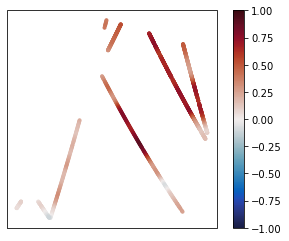

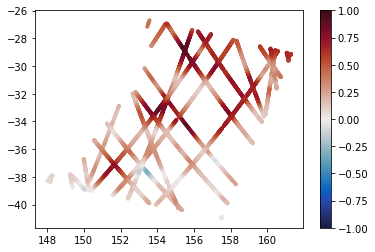

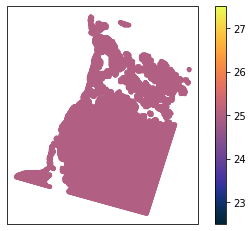

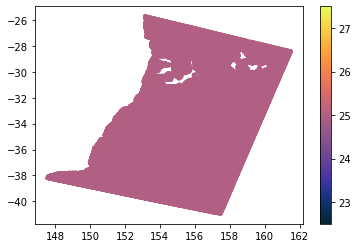

In [7]:
# SSH
# Single day plot
provValue=405
v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)
la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)

fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
ax = plt.scatter(x=lo,y=la,c=v,marker='.',cmap = cmaps.cmocean_balance, vmin=-1, vmax=1)
ax = plt.colorbar()


# all days plot
fig = plt.figure()
plt.scatter(x=obs.obs_lon.where(obs.obs_provenance==provValue),y=obs.obs_lat.where(obs.obs_provenance==provValue),c=obs.obs_value.where(obs.obs_provenance==provValue),marker='.',cmap=cmaps.cmocean_balance, vmin=-1, vmax=1)
plt.colorbar()

# SST
provValue = 340
# Single day plot
v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)
la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)

fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
ax = plt.scatter(x=lo,y=la,c=v,marker='.',cmap = cmaps.cmocean_thermal)
ax = plt.colorbar()


# all days plot
fig = plt.figure()
plt.scatter(x=obs.obs_lon.where(obs.obs_provenance==provValue),y=obs.obs_lat.where(obs.obs_provenance==provValue),c=obs.obs_value.where(obs.obs_provenance==provValue),marker='.',cmap=cmaps.cmocean_thermal)
plt.colorbar()

#### Now check the data in each day
This suggests that data is not present for full cycle of assimilation (skips last day)

In [8]:
# print sizes of each day

print(obs.obs_value.where((obs.obs_time>8004) & (obs.obs_time<8005), drop=True).sizes)
print(obs.obs_value.where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True).sizes)
print(obs.obs_value.where((obs.obs_time>8006) & (obs.obs_time<8007), drop=True).sizes)
print(obs.obs_value.where((obs.obs_time>8007) & (obs.obs_time<8008), drop=True).sizes)
print(obs.obs_value.where((obs.obs_time>8008) & (obs.obs_time<8009), drop=True).sizes)
print(obs.obs_value.where((obs.obs_time>8009) & (obs.obs_time<8010), drop=True).sizes)

Frozen({'datum': 0})
Frozen({'datum': 37923})
Frozen({'datum': 30287})
Frozen({'datum': 33820})
Frozen({'datum': 18252})
Frozen({'datum': 22902})


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008


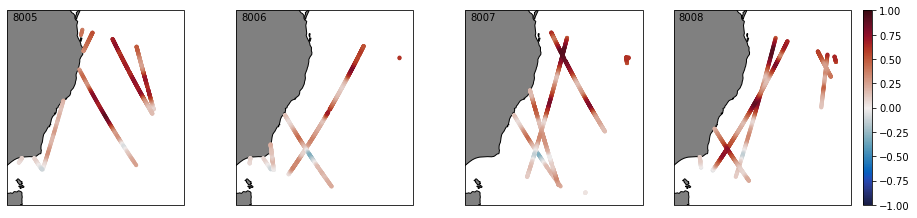

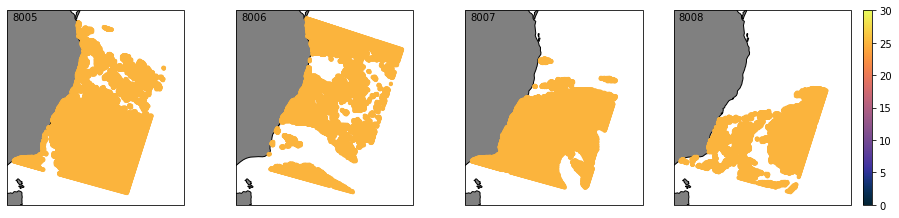

In [9]:
# split data up by day

tRange=np.arange(8005,8013,1)

provValue=405
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

provValue=340
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=0, vmax=30, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

opening 8005.nc
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 0 1
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 1 2
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 2 3
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 3 4
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 4 5
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 5 6
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 6 7
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 7 8
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8 9
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 9 10
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 10 11
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 11 12
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 12 13
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 13 14
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 14 15
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 15 16
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 16 17
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 17 18
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 18 19
<class 'cartopy.mpl.geoaxes.GeoAxe

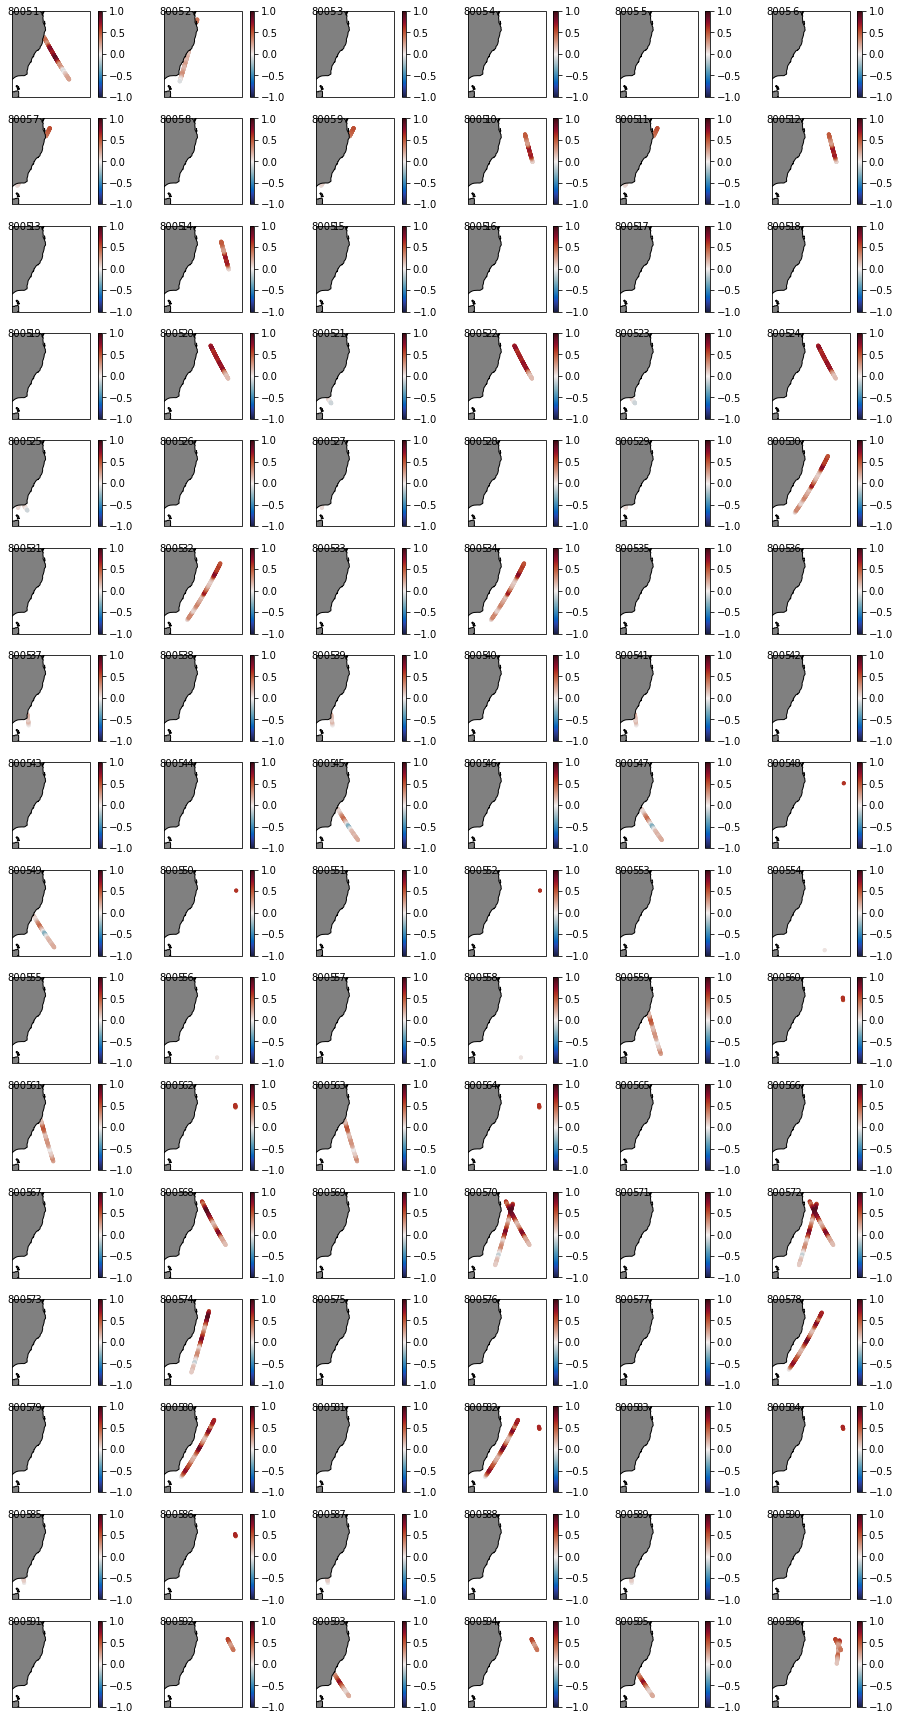

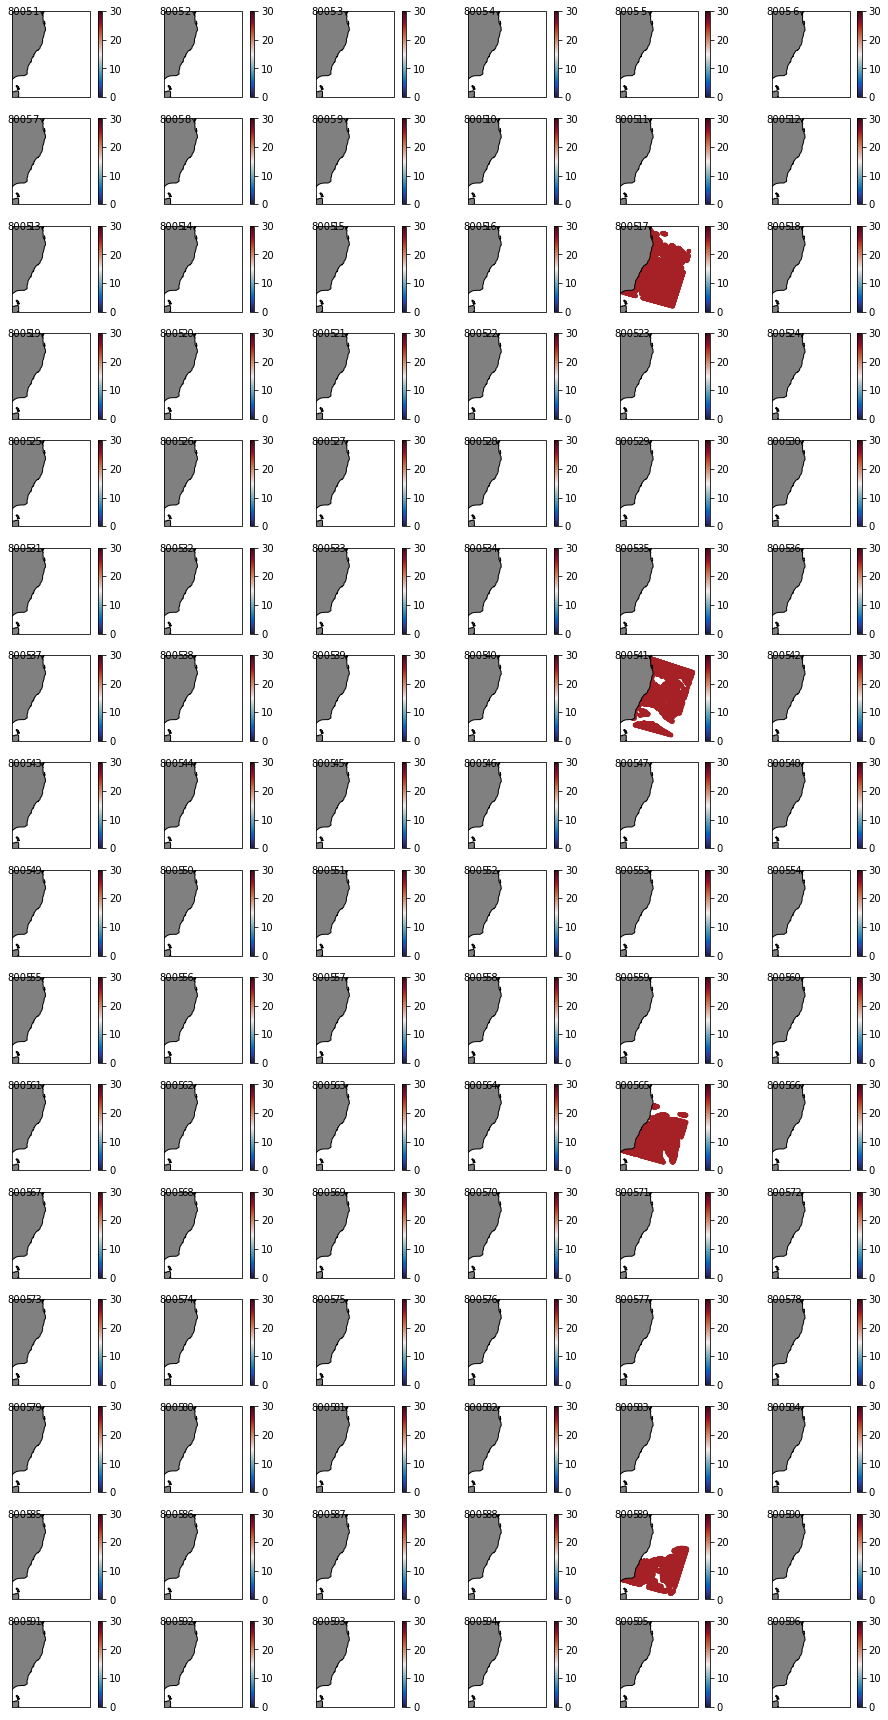

In [10]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)
for day in np.arange(dStart,dEnd,assimPeriod-assimOverlap): 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsFilePath+'/verification/'+obsPrefix+obsFileName
    print('opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    tRangeStart=np.arange(day,day+assimPeriod,1/24)
    tRangeEnd=np.arange(day+1/24,day+assimPeriod+1/24,1/24)

    fig = plt.figure(figsize=(13,24))
    iSz,jSz = (16,6)
    gs = fig.add_gridspec(iSz, jSz)

    for ax, tStart, tEnd in zip(range(iSz*jSz), tRangeStart, tRangeEnd):
        ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
        print(type(ax), round((tStart-tRangeStart[0])*24), round((tEnd-tRangeStart[0])*24))
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)#, vmin=-1, vmax=1, zorder=10)
        ax.text(.3,.95,str(round((tEnd-tRangeStart[0])*24)),horizontalalignment='center',transform=ax.transAxes)
        ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
        cb = fig.colorbar(sc)
    # fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
    plt.tight_layout()
    # plt.savefig('temp.png')


pRange=(340)
for day in np.arange(dStart,dEnd,assimPeriod-assimOverlap): 
    obsFileName = ''+str(day)+'.nc'
    obsPath = obsFilePath+'/verification/'+obsPrefix+obsFileName
    print('opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    tRangeStart=np.arange(day,day+assimPeriod,1/24)
    tRangeEnd=np.arange(day+1/24,day+assimPeriod+1/24,1/24)

    fig = plt.figure(figsize=(13,24))
    iSz,jSz = (16,6)
    gs = fig.add_gridspec(iSz, jSz)

    for ax, tStart, tEnd in zip(range(iSz*jSz), tRangeStart, tRangeEnd):
        ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
        print(type(ax), round((tStart-tRangeStart[0])*24), round((tEnd-tRangeStart[0])*24))
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)#, vmin=-1, vmax=1, zorder=10)
        ax.text(.3,.95,str(round((tEnd-tRangeStart[0])*24)),horizontalalignment='center',transform=ax.transAxes)
        ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([0,30])
        cb = fig.colorbar(sc)
    # fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
    plt.tight_layout()
    # plt.savefig('temp.png')


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416
8005.375
<xarray.DataArray 'obs_value' ()>
array(0.44288304)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(0.44288304)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.44288304)
<xarray.DataArray 'obs_value' ()>
array(25.)


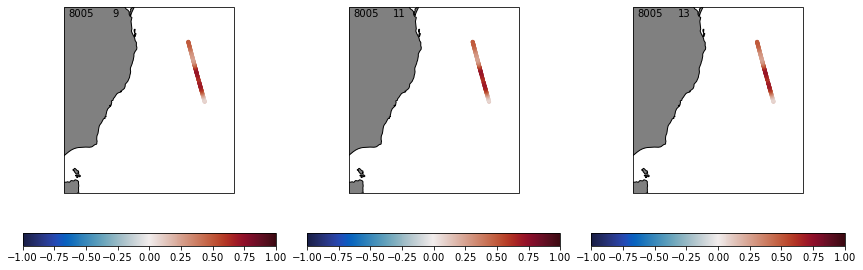

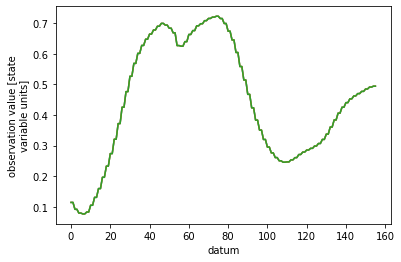

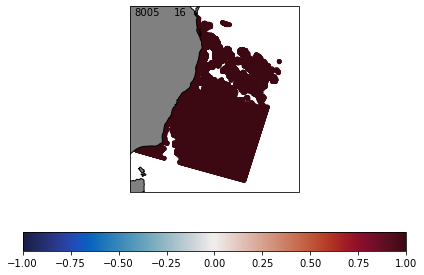

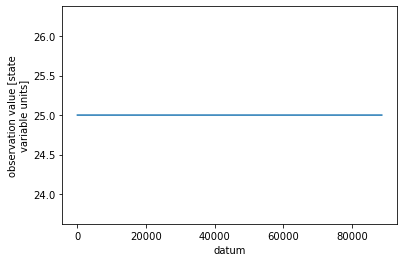

In [11]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)
aa=0/24

tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
for tRangeStart in tRange:
    print(tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

pRange=(340)
tRangeStart = 8005.375+7/24
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
sc.set_clim([-1,1])
fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
v.plot()
print(v.mean())


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008


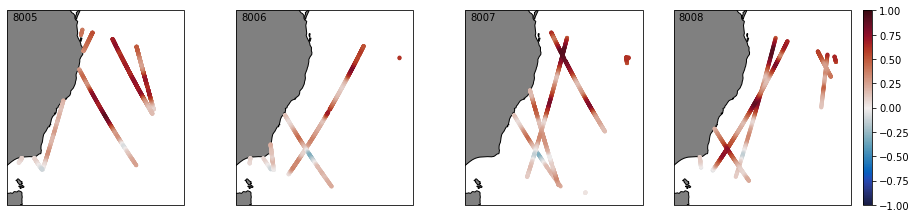

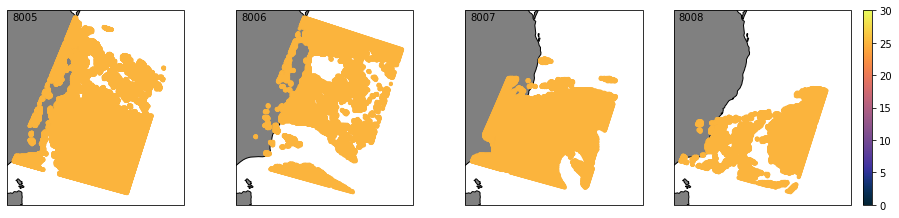

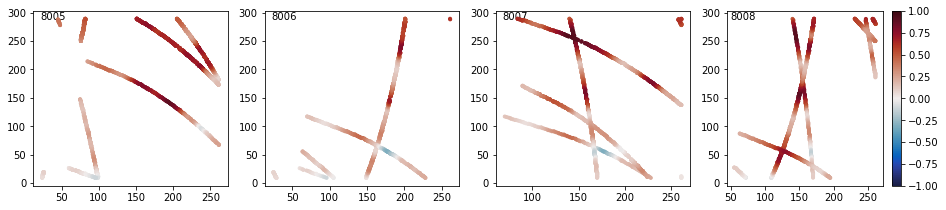

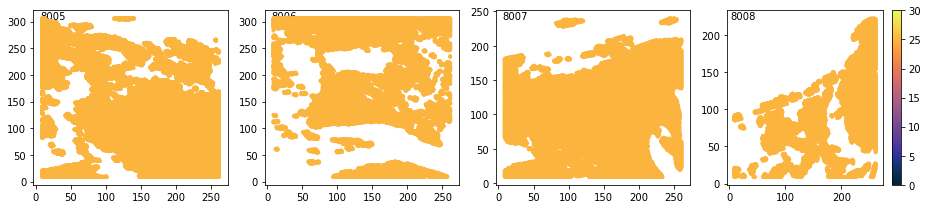

In [12]:
# Compare this...
# split data up by day

tRange=np.arange(8005,8013,1)

provValue=405
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

provValue=340
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=0, vmax=30, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)


# Look at the Xgrid and Ygrid values for SSH and SST obs.

tRange=np.arange(8005,8013,1)

provValue=405
fig, axes = plt.subplots(ncols=4, figsize=(13, 3))
for ax, tRangeStart in zip(axes, tRange):
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    xx=obs.obs_Xgrid.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    yy=obs.obs_Ygrid.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    sc = ax.scatter(x=xx,y=yy,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

provValue=340
fig, axes = plt.subplots(ncols=4, figsize=(13, 3))
for ax, tRangeStart in zip(axes, tRange):
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    xx=obs.obs_Xgrid.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    yy=obs.obs_Ygrid.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    sc = ax.scatter(x=xx,y=yy,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=0, vmax=30, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

# Plot up mod file, which is output from first truth run
Change plots to NLmodel_value, which is the model value at obs_value points(x,y,z,t)

In [13]:
### Load osse obs and mod file data

modPath = '/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/cache/obs_truth_output/eac_mod_08005.nc'

mod = xr.open_dataset(modPath)


In [14]:

# SST
print(mod.obs_depth.where(mod.obs_provenance==340, drop=True).values, mod.obs_depth.where(mod.obs_provenance==340, drop=True).values.mean())
print(mod.obs_Zgrid.where(mod.obs_provenance==340, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==340, drop=True).values.mean())
print(mod.obs_value.where(mod.obs_provenance==340, drop=True).values, mod.obs_value.where(mod.obs_provenance==340, drop=True).values.mean())
print(mod.obs_type.where(mod.obs_provenance==340, drop=True).values, mod.obs_type.where(mod.obs_provenance==340, drop=True).values.mean())

## SSH
print(mod.obs_depth.where(mod.obs_provenance==405, drop=True).values, mod.obs_depth.where(mod.obs_provenance==405, drop=True).values.mean())
print(mod.obs_Zgrid.where(mod.obs_provenance==405, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==405, drop=True).values.mean())
print(mod.obs_value.where(mod.obs_provenance==405, drop=True).values, mod.obs_value.where(mod.obs_provenance==405, drop=True).values.mean())
print(mod.obs_type.where(mod.obs_provenance==405, drop=True).values, mod.obs_type.where(mod.obs_provenance==405, drop=True).values.mean())

[0. 0. 0. ... 0. 0. 0.] 0.0
[30. 30. 30. ... 30. 30. 30.] 30.0
[25. 25. 25. ... 25. 25. 25.] 25.0
[6. 6. 6. ... 6. 6. 6.] 6.0
[0. 0. 0. ... 0. 0. 0.] 0.0
[0. 0. 0. ... 0. 0. 0.] 0.0
[0.26258642 0.26918461 0.28351284 ... 0.17640922 0.16369837 0.14946956] 0.373210164245918
[1. 1. 1. ... 1. 1. 1.] 1.0


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008


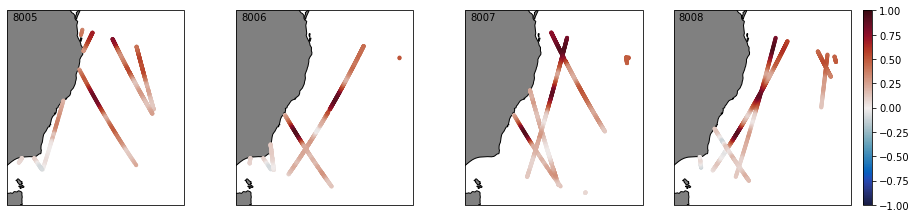

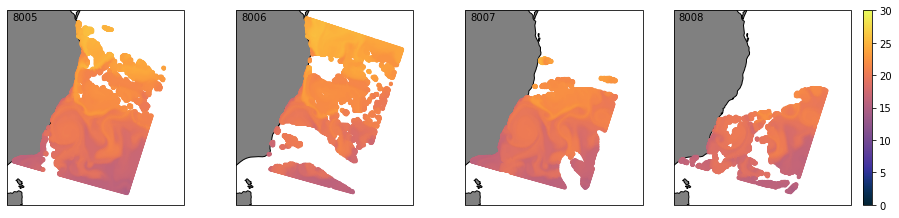

In [15]:
# split data up by day

tRange=np.arange(8005,8013,1)

provValue=405
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

provValue=340
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=0, vmax=30, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416
8005.375
<xarray.DataArray 'NLmodel_value' ()>
array(0.36306344)
8005.4583
<xarray.DataArray 'NLmodel_value' ()>
array(0.36264345)
8005.5416
<xarray.DataArray 'NLmodel_value' ()>
array(0.36429622)
<xarray.DataArray 'NLmodel_value' ()>
array(20.3603696)


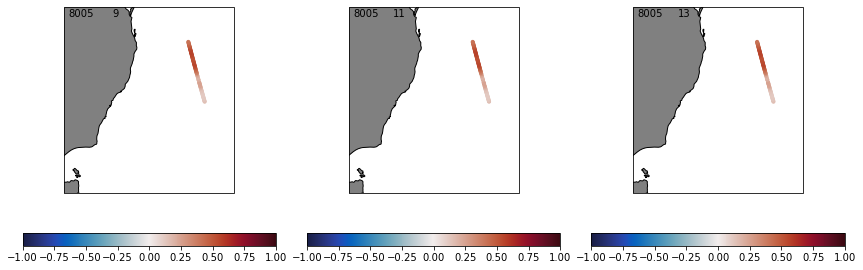

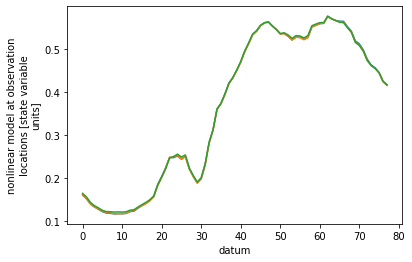

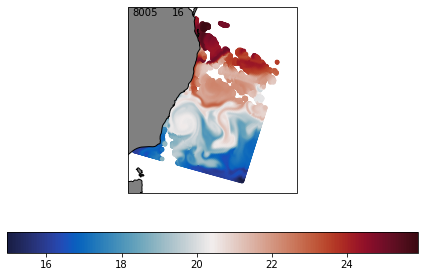

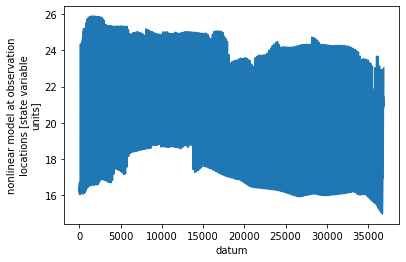

In [16]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)
aa=0/24

tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

pRange=(340)
tRangeStart = 8005.375+7/24
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
# sc.set_clim([-1,1])
fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
v.plot()
print(v.mean())


# Plot up obs file (final).
This file is the original verification obs file, but combined with values from the mod file + some noise

In [17]:

obsPath = '/Users/dave/Documents/dave/Projects/ROMS_ObsPrep/data/out/obs_final/eac_obs_8005.nc'

obs = xr.open_dataset(obsPath)

In [18]:

# SST
print('obs_depth',obs.obs_depth.where(obs.obs_provenance==340, drop=True).values, obs.obs_depth.where(obs.obs_provenance==340, drop=True).values.mean())
print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==340, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==340, drop=True).values.mean())
print('obs_value',obs.obs_value.where(obs.obs_provenance==340, drop=True).values, obs.obs_value.where(obs.obs_provenance==340, drop=True).values.mean())
print('obs_type',obs.obs_type.where(obs.obs_provenance==340, drop=True).values, obs.obs_type.where(obs.obs_provenance==340, drop=True).values.mean())

## SSH
print('obs_depth',obs.obs_depth.where(obs.obs_provenance==405, drop=True).values, obs.obs_depth.where(obs.obs_provenance==405, drop=True).values.mean())
print('obs_Zgrid',obs.obs_Zgrid.where(obs.obs_provenance==405, drop=True).values, obs.obs_Zgrid.where(obs.obs_provenance==405, drop=True).values.mean())
print('obs_value',obs.obs_value.where(obs.obs_provenance==405, drop=True).values, obs.obs_value.where(obs.obs_provenance==405, drop=True).values.mean())
print('obs_type',obs.obs_type.where(obs.obs_provenance==405, drop=True).values, obs.obs_type.where(obs.obs_provenance==405, drop=True).values.mean())

obs_depth [30. 30. 30. ... 30. 30. 30.] 30.0
obs_Zgrid [0. 0. 0. ... 0. 0. 0.] 0.0
obs_value [16.83089111 17.07906821 16.88988341 ... 23.56248442 23.54285438
 24.13141167] 20.461404458173554
obs_type [6. 6. 6. ... 6. 6. 6.] 6.0
obs_depth [0. 0. 0. ... 0. 0. 0.] 0.0
obs_Zgrid [30. 30. 30. ... 30. 30. 30.] 30.0
obs_value [0.19485456 0.22782375 0.27977592 ... 0.16399507 0.2058637  0.14797931] 0.33322119178412496
obs_type [1. 1. 1. ... 1. 1. 1.] 1.0


8005.375
<xarray.DataArray 'obs_value' ()>
array(0.35904808)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(0.35694262)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.36389525)


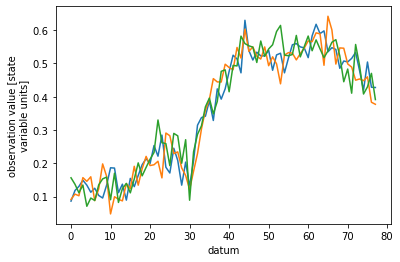

In [19]:
# plots of obs_value (which is the value we duplicated and put into the original obs file)

dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008


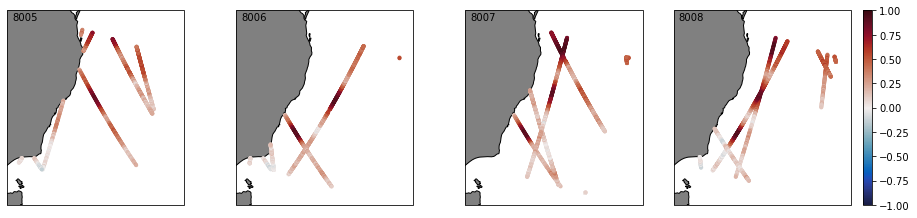

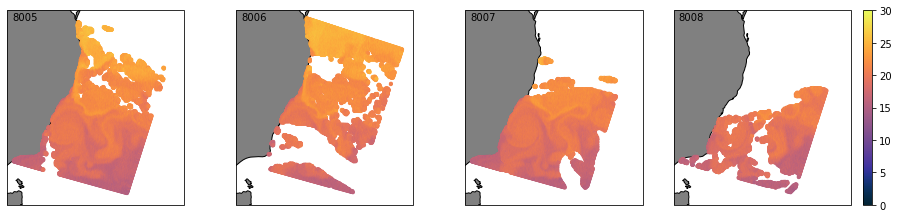

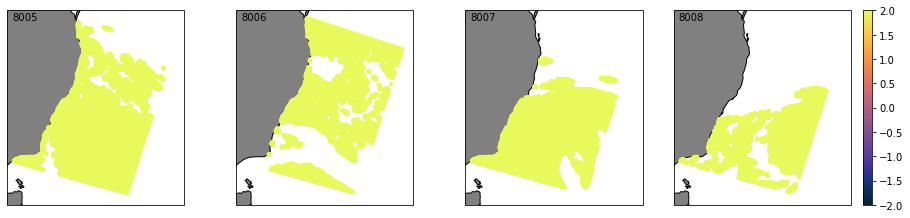

In [20]:
# split data up by day

tRange=np.arange(8005,8013,1)

provValue=405
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

provValue=340
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=0, vmax=30, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)


fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==provValue).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=-2, vmax=2, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416
8005.375
<xarray.DataArray 'obs_value' ()>
array(0.35904808)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(0.35694262)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.36389525)
<xarray.DataArray 'obs_value' ()>
array(20.36139603)


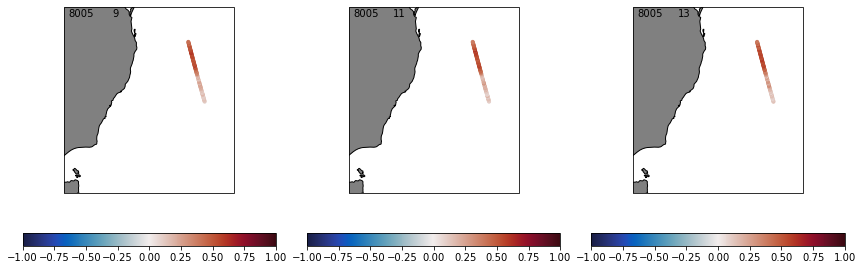

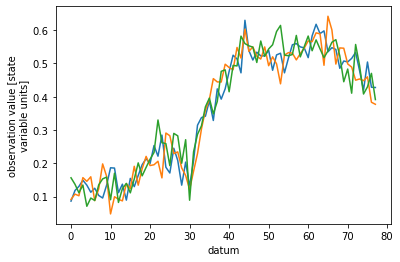

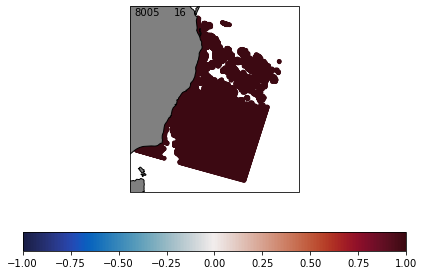

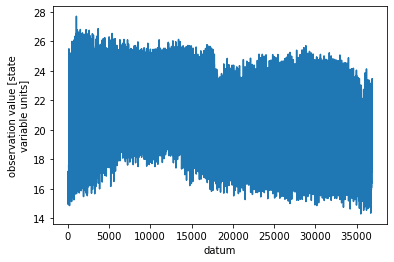

In [21]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)
aa=0/24

tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
for tRangeStart in tRange:
    print(tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

pRange=(340)
tRangeStart = 8005.375+7/24
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
sc.set_clim([-1,1])
fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
v.plot()
print(v.mean())


# Plot up output of mod file from OSSE

In [22]:
# obsPath = '../data/raw/eac_obs_8005.nc'
# hisPath = '../data/raw/'
modPath = '../data/raw/OSSE_SSHSST/eac_mod_08005.nc'
# truthPath = '../data/raw/run1/truth/outer_his_08005.nc'
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

mod = xr.open_dataset(modPath)
# obs = xr.open_dataset(obsPath)
hisFor = xr.open_dataset('../data/raw/OSSE_SSHSST/'+prefixForecast+'08005.nc')
hisAna = xr.open_dataset('../data/raw/OSSE_SSHSST/'+prefixAnalysis+'08005.nc')
# hisTru = xr.open_dataset(truthPath)


In [23]:

# SST
print(mod.obs_depth.where(mod.obs_provenance==340, drop=True).values, mod.obs_depth.where(mod.obs_provenance==340, drop=True).values.mean())
print(mod.obs_Zgrid.where(mod.obs_provenance==340, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==340, drop=True).values.mean())
print(mod.obs_value.where(mod.obs_provenance==340, drop=True).values, mod.obs_value.where(mod.obs_provenance==340, drop=True).values.mean())
print(mod.obs_type.where(mod.obs_provenance==340, drop=True).values, mod.obs_type.where(mod.obs_provenance==340, drop=True).values.mean())

## SSH
print(mod.obs_depth.where(mod.obs_provenance==405, drop=True).values, mod.obs_depth.where(mod.obs_provenance==405, drop=True).values.mean())
print(mod.obs_Zgrid.where(mod.obs_provenance==405, drop=True).values, mod.obs_Zgrid.where(mod.obs_provenance==405, drop=True).values.mean())
print(mod.obs_value.where(mod.obs_provenance==405, drop=True).values, mod.obs_value.where(mod.obs_provenance==405, drop=True).values.mean())
print(mod.obs_type.where(mod.obs_provenance==405, drop=True).values, mod.obs_type.where(mod.obs_provenance==405, drop=True).values.mean())

[0. 0. 0. ... 0. 0. 0.] 0.0
[30. 30. 30. ... 30. 30. 30.] 30.0
[16.83089111 17.07906821 16.88988341 ... 23.56248442 23.54285438
 24.13141167] 20.461404458173554
[6. 6. 6. ... 6. 6. 6.] 6.0
[0. 0. 0. ... 0. 0. 0.] 0.0
[0. 0. 0. ... 0. 0. 0.] 0.0
[0.19485456 0.22782375 0.27977592 ... 0.16399507 0.2058637  0.14797931] 0.33322119178412496
[1. 1. 1. ... 1. 1. 1.] 1.0


<xarray.DataArray 'NLmodel_final' ()>
array(0.38996153)
<xarray.DataArray 'NLmodel_final' ()>
array(20.47673406)
<ipython-input-24-f946dcff8363>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, v, marker='.', markersize=1, lineStyle='None',label='NLmodel_final',zorder=10)
<ipython-input-24-f946dcff8363>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, vi, marker='.', markersize=5, lineStyle='None',label='NLmodel_initial',zorder=5)
<ipython-input-24-f946dcff8363>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, vobs, marker='.', markersize=10, lineStyle='None',label='obs_value',zorder=1)
<ipython-input-24-f946dcff8363>:29: MatplotlibDeprecationWarning: Case-insensitive properties were d

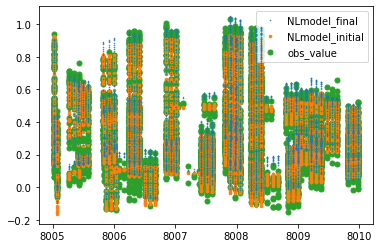

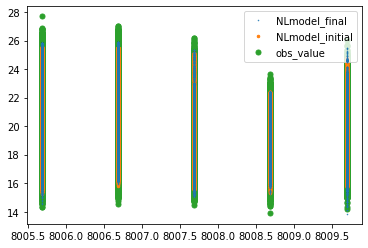

In [24]:
dStart=8005
dEnd=8009

pRange=(405)
v=mod.NLmodel_final.where(mod.obs_provenance==pRange)
vi=mod.NLmodel_initial.where(mod.obs_provenance==pRange)
vobs=mod.obs_value.where(mod.obs_provenance==pRange)
lo=mod.obs_lon.where(mod.obs_provenance==pRange)
la=mod.obs_lat.where(mod.obs_provenance==pRange)
t=mod.obs_time.where(mod.obs_provenance==pRange)
fig = plt.figure()
ax = plt.axes()
ax.plot(t, v, marker='.', markersize=1, lineStyle='None',label='NLmodel_final',zorder=10)
ax.plot(t, vi, marker='.', markersize=5, lineStyle='None',label='NLmodel_initial',zorder=5)
ax.plot(t, vobs, marker='.', markersize=10, lineStyle='None',label='obs_value',zorder=1)
ax.legend()
print(v.mean())


pRange=(340)
v=mod.NLmodel_final.where(mod.obs_provenance==pRange)
vi=mod.NLmodel_initial.where(mod.obs_provenance==pRange)
vobs=mod.obs_value.where(mod.obs_provenance==pRange)
lo=mod.obs_lon.where(mod.obs_provenance==pRange)
la=mod.obs_lat.where(mod.obs_provenance==pRange)
t=mod.obs_time.where(mod.obs_provenance==pRange)
fig = plt.figure()
ax = plt.axes()
ax.plot(t, v, marker='.', markersize=1, lineStyle='None',label='NLmodel_final',zorder=10)
ax.plot(t, vi, marker='.', markersize=5, lineStyle='None',label='NLmodel_initial',zorder=5)
ax.plot(t, vobs, marker='.', markersize=10, lineStyle='None',label='obs_value',zorder=1)
ax.legend()
print(v.mean())

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008


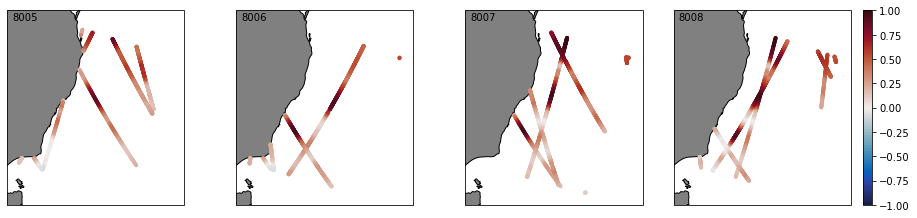

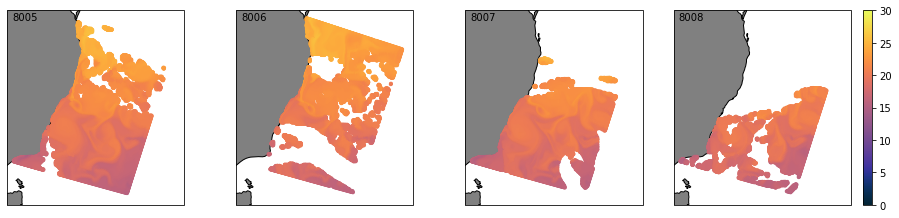

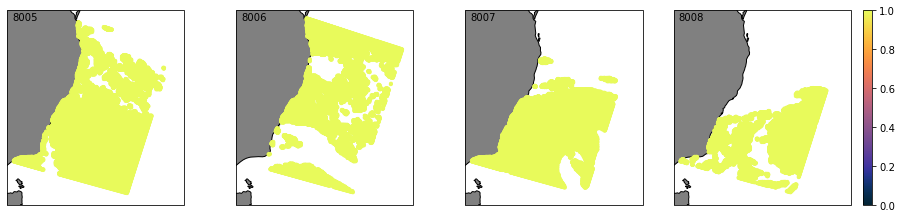

In [25]:
 # split data up by day

tRange=np.arange(8005,8013,1)

provValue=405
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

provValue=340
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=0, vmax=30, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

provValue=340
fig, axes = plt.subplots(ncols=4, figsize=(13, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, vmin=0, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416
8005.375
<xarray.DataArray 'NLmodel_value' ()>
array(0.38388693)
8005.4583
<xarray.DataArray 'NLmodel_value' ()>
array(0.3795935)
8005.5416
<xarray.DataArray 'NLmodel_value' ()>
array(0.38493519)
<xarray.DataArray 'NLmodel_value' ()>
array(20.37268436)


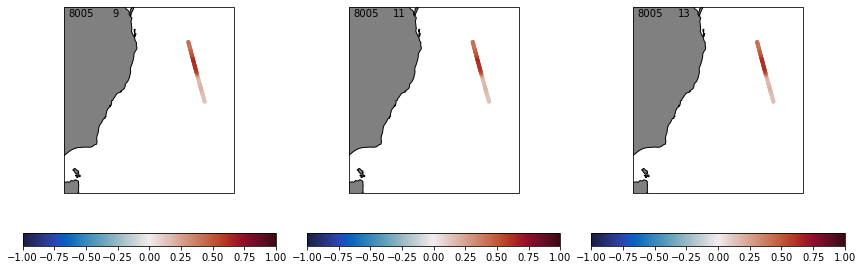

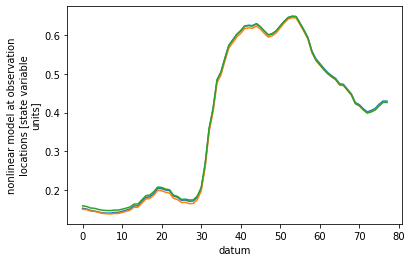

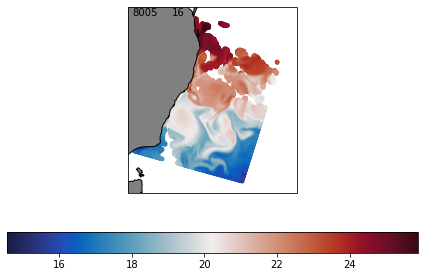

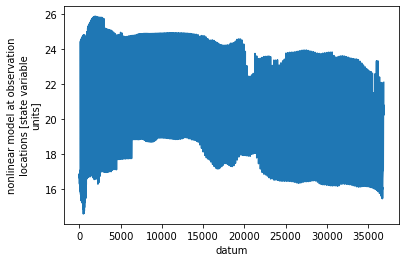

In [26]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)
aa=0/24

tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

pRange=(340)
tRangeStart = 8005.375+7/24
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
# sc.set_clim([-1,1])
fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


fig = plt.figure()
v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
v.plot()
print(v.mean())


In [27]:
epochY,epochm,epochd,epochH,epochM=1990,1,1,0,0

print(serial_day_to_datestring(8005))
print(datestring_to_serial_day('2011-12-05 14:30'))

2011-12-02 00:00
8008.604166666667


In [28]:
# import pandas as pd
# print(pd.to_datetime(8005.375,unit='d'))
# print(pd.to_datetime(8005.5416,unit='d'))


# timeRange = slice('2011-12-02 09:00:00', '2011-12-02 13:00:00')

# hisInTime = hisTru.sel(ocean_time=timeRange).isel(ocean_time=0)

# aa=0/24
# tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
# pRange=(405)
# zeta = hisInTime.zeta
# fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# for ax, tRangeStart in zip(axes, tRange):
#     print(type(ax), tRangeStart)
#     v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
#     lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
#     la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
#     t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
#     ax.set_extent([147, 162.5, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im=zeta.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, vmin=-1, vmax=1, cmap=cmaps.cmocean_balance)
#     # im = zeta.plot.pcolormesh()
#     sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
#     ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
#     ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
#     sc.set_clim([-1,1])
#     fig.colorbar(sc, ax=ax, orientation='horizontal')
# # plt.tight_layout()

### Look at Xgrid, Ygrid

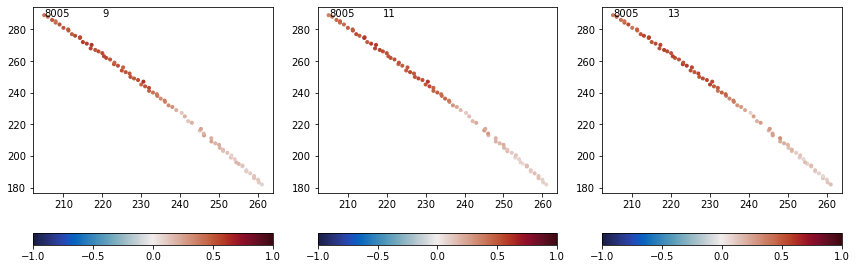

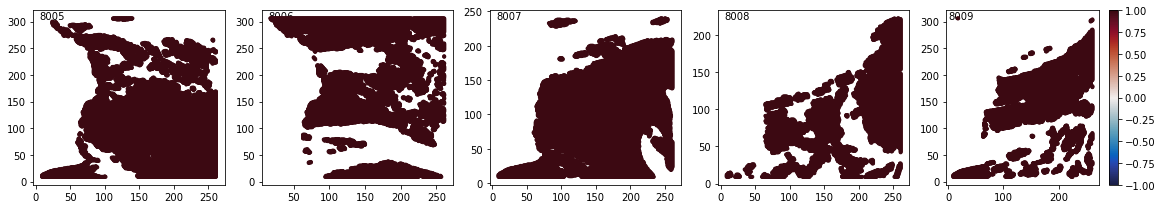

In [29]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for ax, tRangeStart in zip(axes, tRange):
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    x=obs.obs_Xgrid.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    y=obs.obs_Ygrid.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    sc = ax.scatter(x=x,y=y,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


tRange=np.arange(8005,8013,1)
pRange=(340)

fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
for ax, tRangeStart in zip(axes, tRange):
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    x=obs.obs_Xgrid.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    y=obs.obs_Ygrid.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    sc = ax.scatter(x=x,y=y,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

In [30]:
# timeSlice = slice('2011-12-02 09:00:00', '2011-12-02 17:00:00')

# fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# hisFor.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).zeta.plot.pcolormesh(ax=axes[0])
# hisAna.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).zeta.plot.pcolormesh(ax=axes[1])
# hisTru.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).zeta.plot.pcolormesh(ax=axes[2])

In [31]:
# hisTru.sel(ocean_time=timeSlice).mean('ocean_time', skipna=True).temp.isel(s_rho=-1).plot.pcolormesh(vmin=16,vmax=26)


### NOW INVESTIGATE SST VALUES >:O

In [32]:
obsPath = '../data/raw/eac_obs_8005.nc'
modPath = '../data/raw/eac_mod_08005.nc'

obs = xr.open_dataset(obsPath)
mod = xr.open_dataset(modPath)


dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(340)

tRange=np.array([dStart, dEnd])


v=mod.NLmodel_value.where(mod.obs_provenance==pRange).sel(Nouter=0)
vobs=mod.obs_value.where(mod.obs_provenance==pRange)

lo=mod.obs_lon.where(mod.obs_provenance==pRange)
la=mod.obs_lat.where(mod.obs_provenance==pRange)
t=mod.obs_time.where(mod.obs_provenance==pRange)

fig = plt.figure()
ax = plt.axes()
ax.plot(t, v,marker='.',lineStyle='None',label='NLmodel_value',zorder=10)
ax.plot(t, vobs,marker='.',lineStyle='None',label='obs_value',zorder=9)
ax.legend()
print(v.mean())



FileNotFoundError: [Errno 2] No such file or directory: b'/Users/dave/Documents/dave/Projects/OSSE-analysis/data/raw/eac_obs_8005.nc'

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009


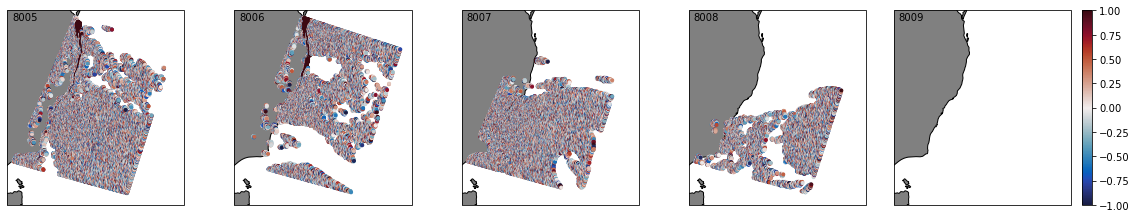

In [132]:

tRange=np.arange(8005,8013,1)
pRange=(340)

fig, axes = plt.subplots(ncols=5, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009


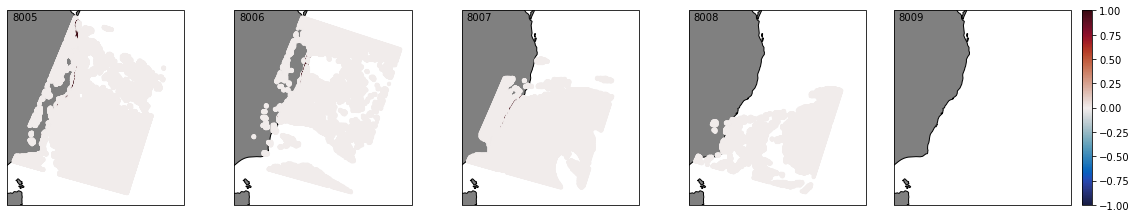

In [141]:
tRange=np.arange(8005,8013,1)
pRange=(340)

fig, axes = plt.subplots(ncols=5, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_final.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)